In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

# Add repo root to sys.path only if it isn't there already
REPO_ROOT = Path.cwd().resolve().parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Autoreload so edits to .py files appear in the notebook without restart
%load_ext autoreload
%autoreload 2

# Import the public API of your library
from hedging import delta_hedging, utility_based_hedging

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": True,                     # render all text with LaTeX
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "axes.labelsize": 12,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.dpi": 110,
        "axes.formatter.useoffset": False,       # no 1e‑4 offsets on axes ticks
    }
)

In [3]:
# Simulation parameters
S0 = 100.0                          # Initial stock price
K = 100.0                           # Strike price of the option
T = 1.0                             # Time to expiration (years)
sigma = 0.20                        # Static volatility (20%)
r = 0.05                            # Risk-free rate (5%)
q = 0.0                             # Dividend yield
dt = 1 / 252                        # Daily time step (252 trading days/year)
n_periods = 252                     # Total number of periods (1 year)
hedging_frequency = 1               # Rebalance every period (daily hedging)
option_type = "call"                # Option type ("put" or "call")
transaction_cost_static = 0.001     # Fixed transaction cost (0.1%)
random_state = 5

In [4]:
delta_results = delta_hedging(
    S0=S0,
    K=K,
    T=T,
    sigma=sigma,
    r=r,
    dt=dt,
    n_periods=n_periods,
    hedging_frequency=hedging_frequency,
    option_type=option_type,
    q=q,
    transaction_cost=transaction_cost_static,
    random_state=random_state,
    dynamic_vol=False,         
    dynamic_trans_cost=False,          
)

In [5]:
utility_results = utility_based_hedging(
    S0=S0,
    K=K,
    T=T,
    sigma=sigma,
    r=r,
    dt=dt,
    n_periods=n_periods,
    hedging_frequency=hedging_frequency,
    option_type=option_type,
    q=q,
    transaction_cost=transaction_cost_static,
    risk_aversion=1.0,         
    no_trade_multiplier=0.2,   
    random_state=random_state,
    dynamic_vol=False,        
    dynamic_trans_cost=False, 
)

In [6]:
# Print Key Outputs
print("Delta‑Hedging Strategy")
print(f"  Final P&L                 : ${delta_results['total_pnl']:.2f}")
print(f"  Cumulative Transaction $  : ${delta_results['transaction_costs']:.4f}")
print(f"  Last Stock Price          : ${delta_results['stock_prices'].iloc[-1]:.2f}")

print("\nUtility‑Based Strategy")
print(f"  Final P&L                 : ${utility_results['total_pnl']:.2f}")
print(f"  Cumulative Transaction $  : ${utility_results['transaction_costs']:.4f}")
print(f"  Last Stock Price          : ${utility_results['stock_prices'].iloc[-1]:.2f}")

Delta‑Hedging Strategy
  Final P&L                 : $19.96
  Cumulative Transaction $  : $0.3561
  Last Stock Price          : $88.61

Utility‑Based Strategy
  Final P&L                 : $0.62
  Cumulative Transaction $  : $0.1623
  Last Stock Price          : $88.61


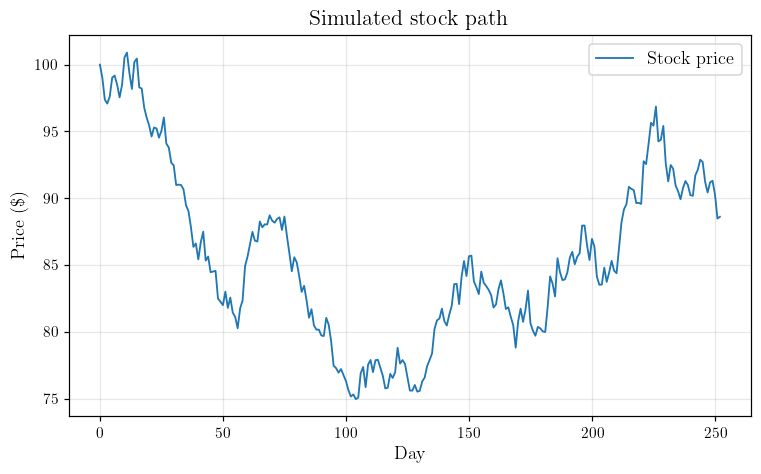

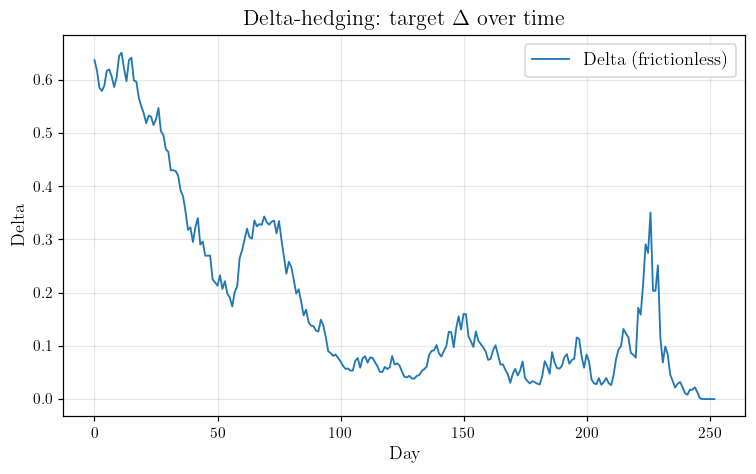

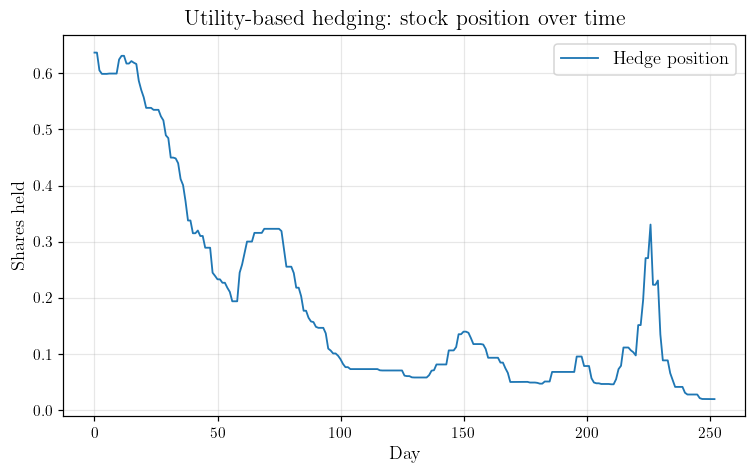

In [7]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(delta_results["stock_prices"], label="Stock price", lw=1.2)
ax.set(title="Simulated stock path", xlabel="Day", ylabel="Price (\$)")
ax.grid(alpha=0.3)
ax.legend()

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(delta_results["delta_values"], label="Delta (frictionless)", lw=1.2)
ax.set(title="Delta-hedging: target $\Delta$ over time", xlabel="Day", ylabel="Delta")
ax.grid(alpha=0.3)
ax.legend()

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(utility_results["hedge_positions"], label="Hedge position", lw=1.2)
ax.set(
    title="Utility-based hedging: stock position over time",
    xlabel="Day",
    ylabel="Shares held",
)
ax.grid(alpha=0.3)
ax.legend()

plt.show()

In [8]:
from tqdm.notebook import tqdm

multipliers = np.arange(0.1, 3.1, 0.1)          # 0.1 … 3.0  (step 0.1)
records: list[tuple[float, float]] = []

for m in tqdm(multipliers, desc="Utility hedges"):
    util_res = utility_based_hedging(
        S0=S0,
        K=K,
        T=T,
        sigma=sigma,
        r=r,
        dt=dt,
        n_periods=n_periods,
        hedging_frequency=hedging_frequency,
        option_type=option_type,
        q=q,
        transaction_cost=transaction_cost_static,
        risk_aversion=1.0,
        no_trade_multiplier=m,
        random_state=random_state,
        dynamic_vol=False,
        dynamic_trans_cost=False,
    )
    records.append((m, util_res["transaction_costs"]))

cost_grid = pd.DataFrame(records, columns=["no_trade_multiplier", "transaction_costs"])


Utility hedges:   0%|          | 0/30 [00:00<?, ?it/s]

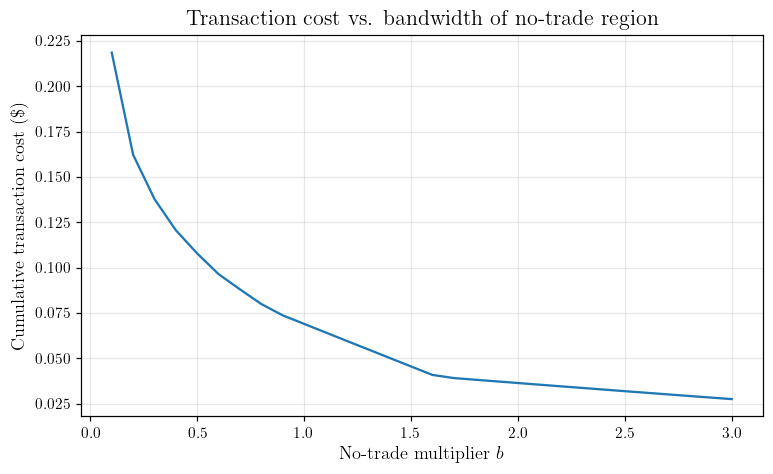

In [9]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(cost_grid["no_trade_multiplier"], cost_grid["transaction_costs"], lw=1.5)
ax.set(
    xlabel="No-trade multiplier $b$",
    ylabel="Cumulative transaction cost (\$)",
    title="Transaction cost vs. bandwidth of no-trade region",
)
ax.grid(alpha=0.3)
plt.show()